These are just your standard interactive scientific python imports that you'll get very used to using.

In [1]:
# built-in python modules
from datetime import datetime,timedelta
import inspect
import os

# scientific python add-ons
import numpy as np
import pandas as pd

# plotting stuff
# first line makes the plots appear in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib as mpl
# seaborn makes your plots look better
try:
    import seaborn as sns
    sns.set(rc={"figure.figsize": (12, 6)})
    sns.set_color_codes()
except ImportError:
    print('We suggest you install seaborn using conda or pip and rerun this cell')

# finally, we import the pvlib library
import pvlib

pvlib forecast module only includes several models. To see the full list of forecast models visit the Unidata website:

http://rredc.nrel.gov/solar/old_data/nsrdb/1991-2005/tmy3/by_state_and_city.html

In [2]:
# Choose a location.
location = [32.2,-110.9] # Tucson, AZ
tz = 'US/Arizona'

Define some PV system parameters.

In [3]:
surface_tilt = 30
surface_azimuth = 180 # pvlib uses 0=North, 90=East, 180=South, 270=West convention
albedo = 0.2

# create pvlib Location object based on meta data
sand_point = pvlib.location.Location(location[0], location[1], altitude=7.0, name='Tucson',tz=tz)
print(sand_point)

Tucson: latitude=32.2, longitude=-110.9, tz=US/Arizona, altitude=7.0


In [4]:
start = datetime.now() # today's date
end = start + timedelta(days=7) # 7 days from today
timerange = pd.date_range(start, end, tz=tz)

In [5]:
# Define forecast model
fm = pvlib.forecast.GFS()

In [6]:
# Retrieve data
forecast_data = fm.get_query_data(location,timerange)

In [7]:
solpos = pvlib.solarposition.get_solarposition(fm.time, sand_point)

In [8]:
fm.addRadiation(solpos.zenith)

Let's look at the downloaded version of the forecast data.

In [9]:
forecast_data.head()

,temperature,temperature_iso,wind_speed,wind_speed_gust,pressure,total_clouds,low_clouds,mid_clouds,high_clouds,boundary_clouds,convect_clouds,downward_shortwave_radflux,downward_shortwave_radflux_avg,dni,dhi,ghi
2015-11-21 00:00:00-07:00,NaN,26.450012,3.663564,3.6,90880.203125,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2015-11-21 03:00:00-07:00,NaN,24.149994,1.636246,1.6,91025.000000,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2015-11-21 06:00:00-07:00,NaN,23.550018,1.127209,1.1,91089.484375,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2015-11-21 09:00:00-07:00,NaN,23.050018,1.963696,2.0,91085.210938,0,0,0,0,0,0,NaN,NaN,106.823313,135.019364,173.170670
2015-11-21 12:00:00-07:00,NaN,20.950012,4.566005,4.5,91075.539062,0,0,0,0,0,0,NaN,NaN,307.189787,194.811046,383.033312


This is a ``pandas DataFrame`` object. It has a lot of great properties that are beyond the scope of our tutorials.

In [10]:
temperature = forecast_data['temperature_iso']
wnd_spd = forecast_data['wind_speed']

Plot the GHI data

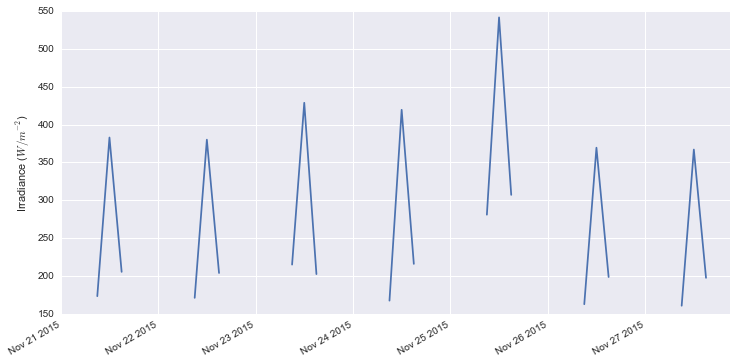

In [11]:
ghi = forecast_data['ghi']
ghi.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)')

## Calculate modeling intermediates

Before we can calculate power for all times in the TMY file, we will need to calculate:
* solar position 
* extra terrestrial radiation
* airmass
* angle of incidence
* POA sky and ground diffuse radiation
* cell and module temperatures

### Solar position

Calculate the solar position for all times in the TMY file. 

The default solar position algorithm is based on Reda and Andreas (2004). Our implementation is pretty fast, but you can make it even faster if you install [``numba``](http://numba.pydata.org/#installing) and use add  ``method='nrel_numba'`` to the function call below.

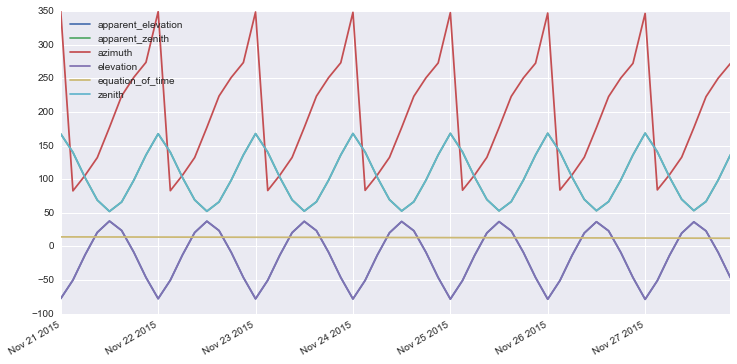

In [12]:
solpos = pvlib.solarposition.get_solarposition(fm.time, sand_point)

solpos.plot()

The funny looking jump in the azimuth is just due to the coarse time sampling in the TMY file.

### DNI ET

Calculate extra terrestrial radiation. This is needed for many plane of array diffuse irradiance models.

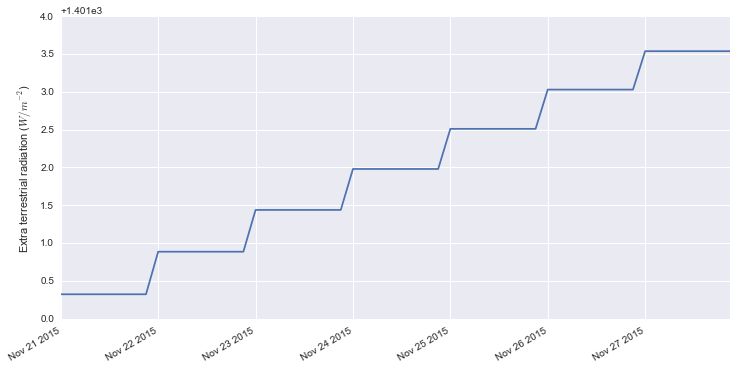

In [13]:
#start = datetime.utcnow() # today's date
#end = start + timedelta(days=365) # 365 days from today
#time = pd.date_range(start,end,freq='H',tz='US/Arizona')

dni_extra = pvlib.irradiance.extraradiation(fm.time)
dni_extra = pd.Series(dni_extra, index=fm.time)

dni_extra.plot()
plt.ylabel('Extra terrestrial radiation ($W/m^{-2}$)')

### Airmass

Calculate airmass. Lots of model options here, see the ``atmosphere`` module tutorial for more details.

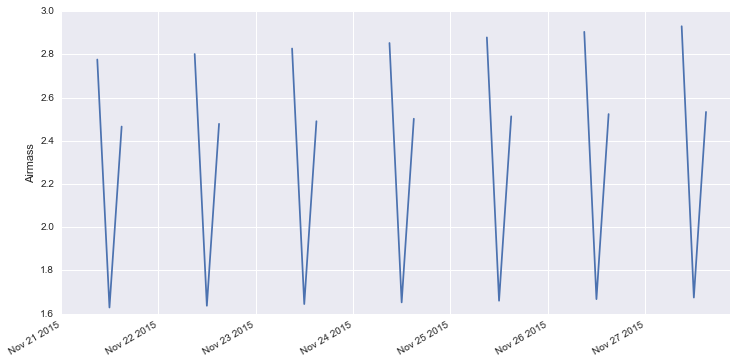

In [14]:
airmass = pvlib.atmosphere.relativeairmass(solpos['apparent_zenith'])

airmass.plot()
plt.ylabel('Airmass')

The funny appearance is due to aliasing and setting invalid numbers equal to ``NaN``. Replot just a day or two and you'll see that the numbers are right.

### POA sky diffuse

Use the Hay Davies model to calculate the plane of array diffuse sky radiation. See the ``irradiance`` module tutorial for comparisons of different models.

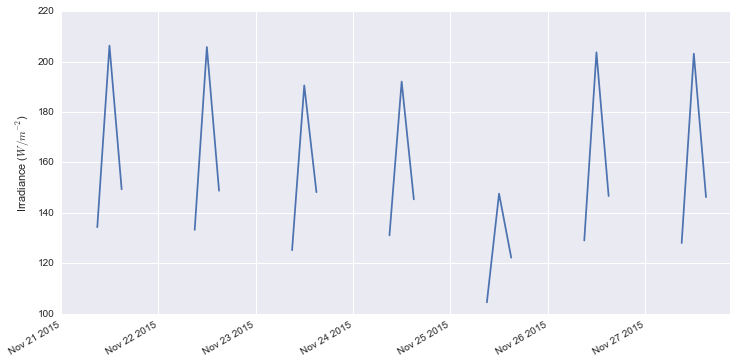

In [15]:
poa_sky_diffuse = pvlib.irradiance.haydavies(surface_tilt, surface_azimuth,
                                             forecast_data['dhi'], forecast_data['dni'], dni_extra,
                                             solpos['apparent_zenith'], solpos['azimuth'])
poa_sky_diffuse.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)')

### POA ground diffuse

Calculate ground diffuse. We specified the albedo above. You could have also provided a string to the ``surface_type`` keyword argument.

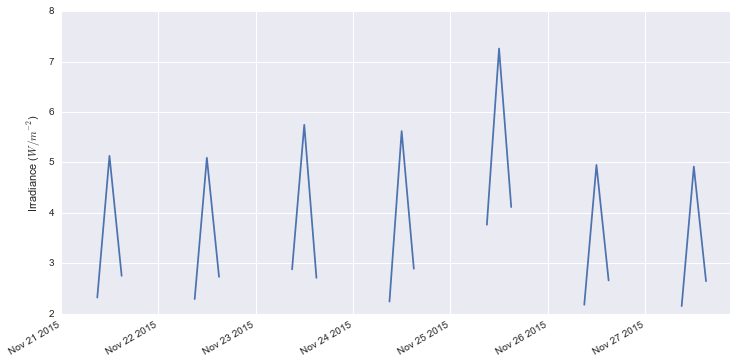

In [16]:
poa_ground_diffuse = pvlib.irradiance.grounddiffuse(surface_tilt, ghi, albedo=albedo)

poa_ground_diffuse.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)')

### AOI

Calculate AOI

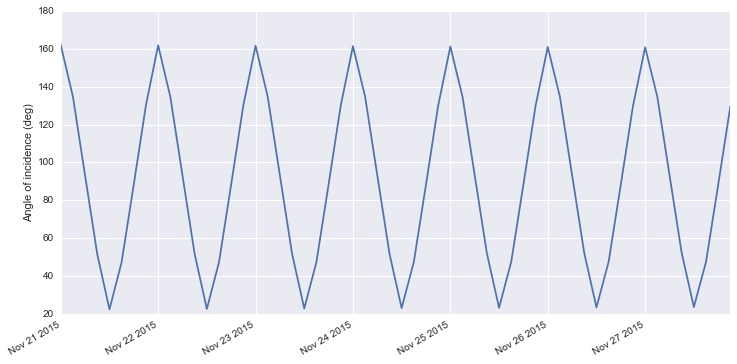

In [17]:
aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth, solpos['apparent_zenith'], solpos['azimuth'])

aoi.plot()
plt.ylabel('Angle of incidence (deg)')

Note that AOI has values greater than 90 deg. This is ok.

### POA total

Calculate POA irradiance

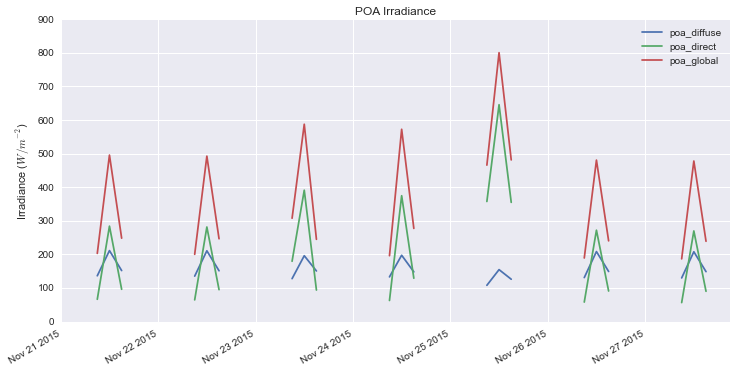

In [18]:
poa_irrad = pvlib.irradiance.globalinplane(aoi, forecast_data['dni'], poa_sky_diffuse, poa_ground_diffuse)

poa_irrad.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)')
plt.title('POA Irradiance')

### Cell and module temperature

Calculate pv cell and module temperature

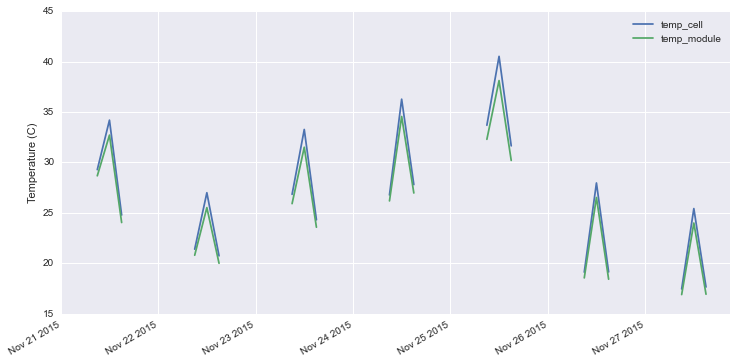

In [19]:
pvtemps = pvlib.pvsystem.sapm_celltemp(poa_irrad['poa_global'], wnd_spd, temperature)

pvtemps.plot()
plt.ylabel('Temperature (C)')

## DC power using SAPM

Get module data from the web.

In [20]:
sandia_modules = pvlib.pvsystem.retrieve_sam(name='SandiaMod')

Choose a particular module

In [21]:
sandia_module = sandia_modules.Canadian_Solar_CS5P_220M___2009_
sandia_module

Vintage                                                          2009
Area                                                            1.701
Material                                                         c-Si
Cells_in_Series                                                    96
Parallel_Strings                                                    1
Isco                                                          5.09115
Voco                                                          59.2608
Impo                                                          4.54629
Vmpo                                                          48.3156
Aisc                                                         0.000397
Aimp                                                         0.000181
C0                                                            1.01284
C1                                                         -0.0128398
Bvoco                                                        -0.21696
Mbvoc               

Run the SAPM using the parameters we calculated above.

                               i_sc      i_mp       v_oc       v_mp  \
2015-11-21 00:00:00-07:00       NaN       NaN        NaN        NaN   
2015-11-21 03:00:00-07:00       NaN       NaN        NaN        NaN   
2015-11-21 06:00:00-07:00       NaN       NaN        NaN        NaN   
2015-11-21 09:00:00-07:00  1.060435  0.955692  52.816629  43.471397   
2015-11-21 12:00:00-07:00  2.553277  2.290126  54.789419  44.995256   

                                 p_mp       i_x      i_xx  \
2015-11-21 00:00:00-07:00         NaN       NaN       NaN   
2015-11-21 03:00:00-07:00         NaN       NaN       NaN   
2015-11-21 06:00:00-07:00         NaN       NaN       NaN   
2015-11-21 09:00:00-07:00   41.545276  1.033531  0.745742   
2015-11-21 12:00:00-07:00  103.044799  2.491085  1.723103   

                           effective_irradiance  
2015-11-21 00:00:00-07:00              0.000000  
2015-11-21 03:00:00-07:00              0.000000  
2015-11-21 06:00:00-07:00              0.000000  
2015-1

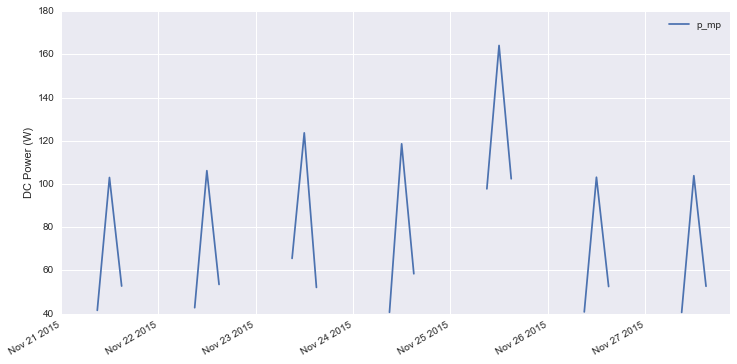

In [22]:
sapm_out = pvlib.pvsystem.sapm(sandia_module, poa_irrad.poa_direct, poa_irrad.poa_diffuse,
                              pvtemps['temp_cell'], airmass, aoi)
print(sapm_out.head())

sapm_out[['p_mp']].plot()
plt.ylabel('DC Power (W)')

## DC power using single diode

In [23]:
cec_modules = pvlib.pvsystem.retrieve_sam(name='CECMod')
cec_module = cec_modules.Canadian_Solar_CS5P_220M

In [24]:
photocurrent, saturation_current, resistance_series, resistance_shunt, nNsVth = (
    pvlib.pvsystem.calcparams_desoto(poa_irrad.poa_global,
                                 temp_cell=pvtemps['temp_cell'],
                                 alpha_isc=cec_module['alpha_sc'],
                                 module_parameters=cec_module,
                                 EgRef=1.121,
                                 dEgdT=-0.0002677) )

In [25]:
single_diode_out = pvlib.pvsystem.singlediode(cec_module, photocurrent, saturation_current,
                                              resistance_series, resistance_shunt, nNsVth)

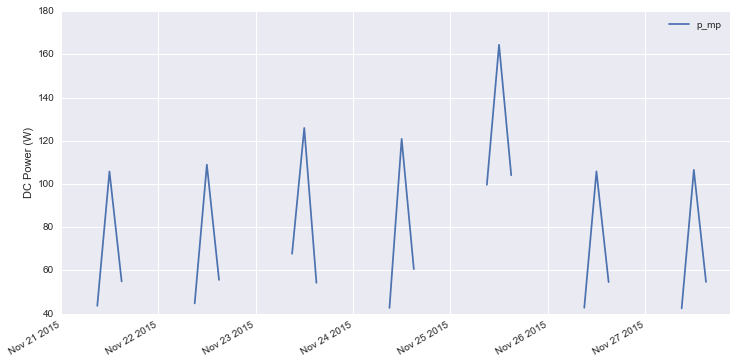

In [26]:
single_diode_out[['p_mp']].plot()
plt.ylabel('DC Power (W)')

## AC power using SAPM

Get the inverter database from the web

In [27]:
sapm_inverters = pvlib.pvsystem.retrieve_sam('sandiainverter')

Choose a particular inverter

In [28]:
sapm_inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_']
sapm_inverter

Vac          208.000000
Paco         250.000000
Pdco         259.522050
Vdco          40.242603
Pso            1.771614
C0            -0.000025
C1            -0.000090
C2             0.000669
C3            -0.018900
Pnt            0.020000
Vdcmax        65.000000
Idcmax        10.000000
Mppt_low      20.000000
Mppt_high     50.000000
Name: ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_, dtype: float64

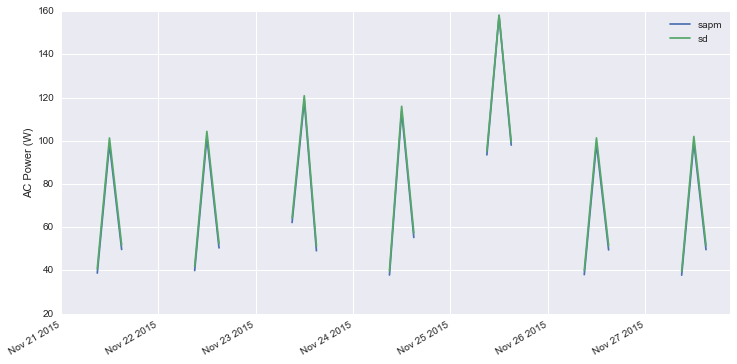

In [29]:
p_acs = pd.DataFrame()
p_acs['sapm'] = pvlib.pvsystem.snlinverter(sapm_inverter, sapm_out.v_mp, sapm_out.p_mp)
p_acs['sd'] = pvlib.pvsystem.snlinverter(sapm_inverter, single_diode_out.v_mp, single_diode_out.p_mp)

p_acs.plot()
plt.ylabel('AC Power (W)')

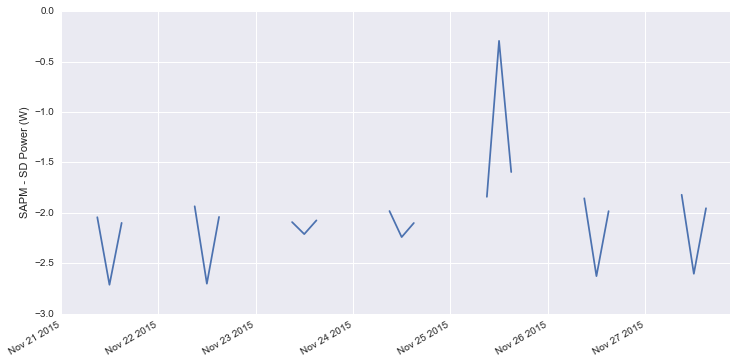

In [30]:
diff = p_acs['sapm'] - p_acs['sd']
diff.plot()
plt.ylabel('SAPM - SD Power (W)')

Plot just a few days.

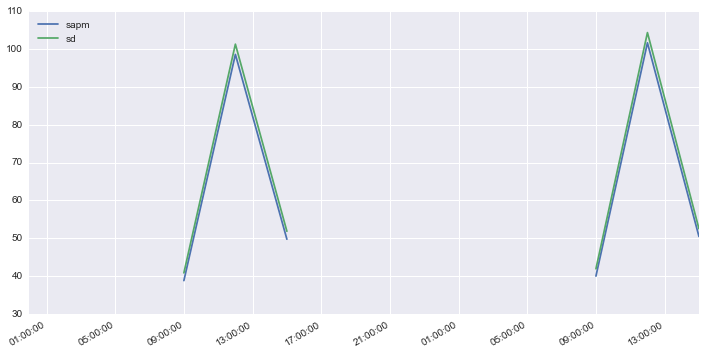

In [31]:
p_acs[start:start+timedelta(days=2)].plot()

Some statistics on the AC power

In [32]:
p_acs.describe()

,sapm,sd
count,21.000000,21.000000
mean,73.288164,75.326466
std,34.600637,34.514244
min,37.854913,39.675335
25%,49.122919,51.197450
50%,55.280175,57.380519
75%,98.743770,101.371158
max,157.927375,158.220773


In [33]:
p_acs.sum()

sapm    1539.051434
sd      1581.855796
dtype: float64

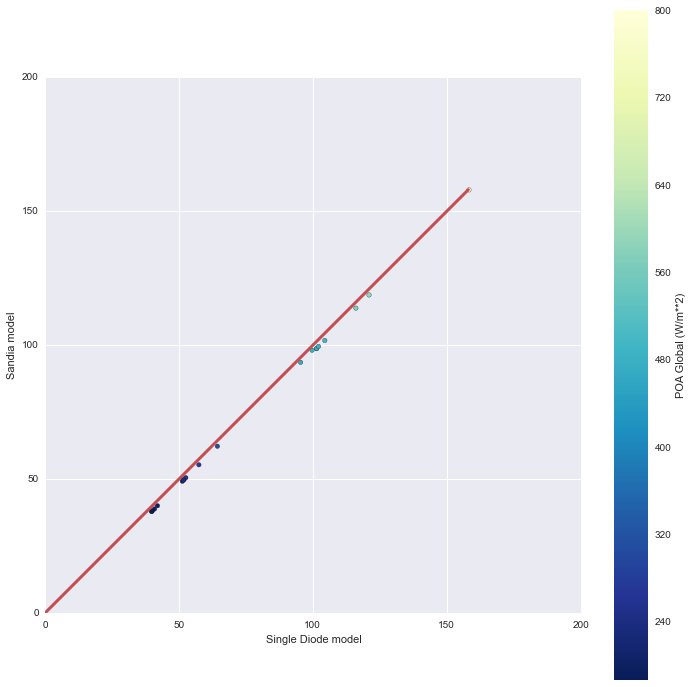

In [34]:
# create data for a y=x line
p_ac_max = p_acs.max().max()
yxline = np.arange(0, p_ac_max)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, aspect='equal')
sc = ax.scatter(p_acs['sd'], p_acs['sapm'], c=poa_irrad.poa_global, alpha=1, cmap=mpl.cm.YlGnBu_r)  
ax.plot(yxline, yxline, 'r', linewidth=3)
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.set_xlabel('Single Diode model')
ax.set_ylabel('Sandia model')
fig.colorbar(sc, label='POA Global (W/m**2)')

We can change the value of color value ``c`` to see the sensitivity of model accuracy to measured meterological conditions. It can be useful to define a simple plotting function for this kind of exploratory analysis.

In [35]:
def sapm_sd_scatter(c_data, label=None, **kwargs):
    """Display a scatter plot of SAPM p_ac vs. single diode p_ac.
    
    You need to re-execute this cell if you re-run the p_ac calculation.
    
    Parameters
    ----------
    c_data : array-like
        Determines the color of each point on the scatter plot.
        Must be same length as p_acs.
        
    kwargs passed to ``scatter``.
    
    Returns
    -------
    tuple of fig, ax objects
    """
    
    nonnull_idx = ~p_acs['sd'].isnull()
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, aspect='equal')
    sc = ax.scatter(p_acs['sd'][nonnull_idx], p_acs['sapm'][nonnull_idx], c=c_data[nonnull_idx], alpha=1, cmap=mpl.cm.YlGnBu_r, **kwargs)  
    ax.plot(yxline, yxline, 'r', linewidth=3)
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel('Single diode model power (W)')
    ax.set_ylabel('Sandia model power (W)')
    fig.colorbar(sc, label='{}'.format(label), shrink=0.75)
    
    return fig, ax

(<matplotlib.figure.Figure at 0xabea908>,
 <matplotlib.axes._subplots.AxesSubplot at 0x8a08748>)

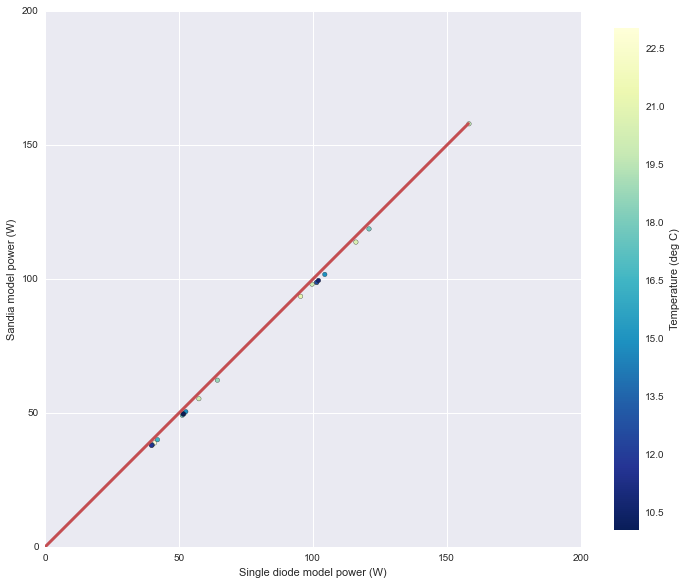

In [36]:
sapm_sd_scatter(temperature, label='Temperature (deg C)')

(<matplotlib.figure.Figure at 0x8b414e0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x8a02c18>)

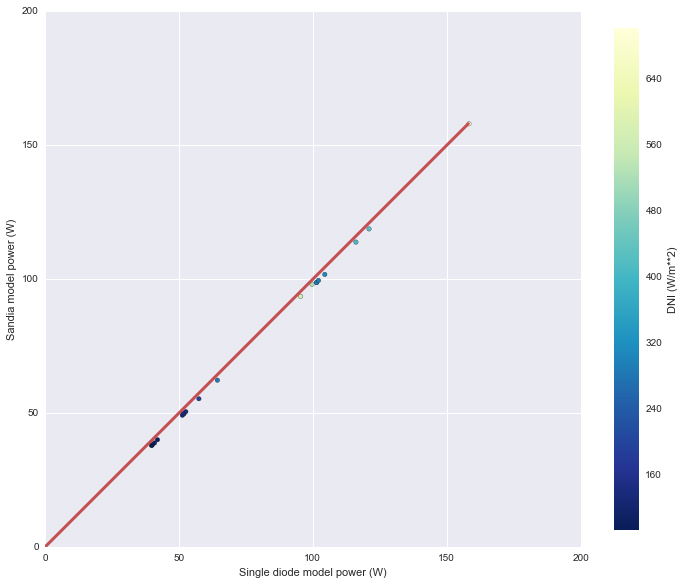

In [37]:
sapm_sd_scatter(forecast_data['dni'], label='DNI (W/m**2)')

(<matplotlib.figure.Figure at 0xb637160>,
 <matplotlib.axes._subplots.AxesSubplot at 0xcd5e828>)

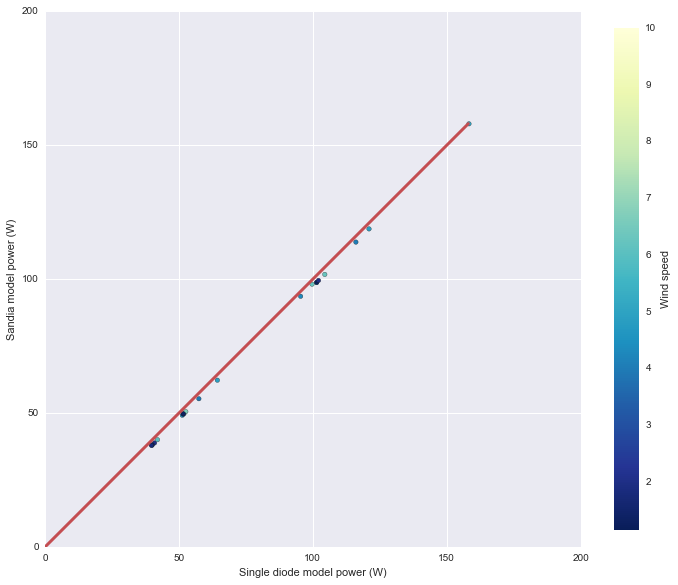

In [38]:
sapm_sd_scatter(wnd_spd, label='Wind speed', vmax=10)

Notice the use of the ``vmax`` keyword argument in the above example. The ``**kwargs`` pattern allows us to easily pass non-specified arguments to nested functions.

In [39]:
def sapm_other_scatter(c_data, x_data, clabel=None, xlabel=None, aspect_equal=False, **kwargs):
    """Display a scatter plot of SAPM p_ac vs. something else.
    
    You need to re-execute this cell if you re-run the p_ac calculation.
    
    Parameters
    ----------
    c_data : array-like
        Determines the color of each point on the scatter plot.
        Must be same length as p_acs.
    x_data : array-like
        
    kwargs passed to ``scatter``.
    
    Returns
    -------
    tuple of fig, ax objects
    """
    
    nonnull_idx = ~p_acs['sapm'].isnull()
    
    fig = plt.figure(figsize=(12,12))
    
    if aspect_equal:
        ax = fig.add_subplot(111, aspect='equal')
    else:
        ax = fig.add_subplot(111)
    sc = ax.scatter(x_data[nonnull_idx], p_acs['sapm'][nonnull_idx], c=c_data[nonnull_idx], alpha=1, cmap=mpl.cm.YlGnBu_r, **kwargs)  
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel('{}'.format(xlabel))
    ax.set_ylabel('Sandia model power (W)')
    fig.colorbar(sc, label='{}'.format(clabel), shrink=0.75)
    
    return fig, ax

(<matplotlib.figure.Figure at 0xe62b780>,
 <matplotlib.axes._subplots.AxesSubplot at 0xe62bef0>)

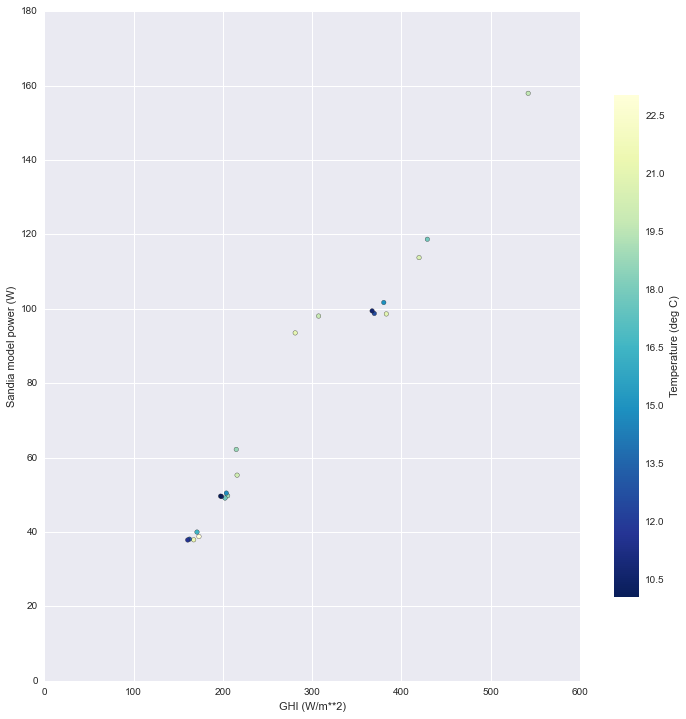

In [40]:
sapm_other_scatter(temperature, forecast_data['ghi'], clabel='Temperature (deg C)', xlabel='GHI (W/m**2)')

Next, we will assume that the SAPM model is representative of the real world performance so that we can use scipy's optimization routine to derive simulated PVUSA coefficients. You will need to install scipy to run these functions.

Here's one PVUSA reference:

http://www.nrel.gov/docs/fy09osti/45376.pdf


In [41]:
def pvusa(pvusa_data, a, b, c, d):
    """
    Calculates system power according to the PVUSA equation
    
    P = I * (a + b*I + c*W + d*T)
    
    where
    P is the output power,
    I is the plane of array irradiance,
    W is the wind speed, and
    T is the temperature
    
    Parameters
    ----------
    pvusa_data : pd.DataFrame
        Must contain the columns 'I', 'W', and 'T'
    a : float
        I coefficient
    b : float
        I*I coefficient
    c : float
        I*W coefficient
    d : float
        I*T coefficient
    
    Returns
    -------
    power : pd.Series
        Power calculated using the PVUSA model.
    """
    return pvusa_data['I'] * (a + b*pvusa_data['I'] + c*pvusa_data['W'] + d*pvusa_data['T'])

In [42]:
from scipy import optimize

In [43]:
pvusa_data_temp = pd.DataFrame()
nonnull_idx = ~poa_irrad.poa_global.isnull()
pvusa_data_temp['I'] = poa_irrad.poa_global
pvusa_data_temp['W'] = wnd_spd
pvusa_data_temp['T'] = temperature
pvusa_data = pvusa_data_temp[nonnull_idx]

In [44]:
popt, pcov = optimize.curve_fit(pvusa, pvusa_data, p_acs.sapm[nonnull_idx].values, p0=(.0001,0.0001,.001,.001))
print('optimized coefs:\n{}'.format(popt))
print('covariances:\n{}'.format(pcov))

optimized coefs:
[  1.87434003e-01  -1.58814681e-05   1.00000000e-03   1.00000000e-03]
covariances:
[[ inf  inf  inf  inf]
 [ inf  inf  inf  inf]
 [ inf  inf  inf  inf]
 [ inf  inf  inf  inf]]


C:\Users\Derek.Groenendyk\Anaconda3\envs\pvlibdev\lib\site-packages\scipy\optimize\minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


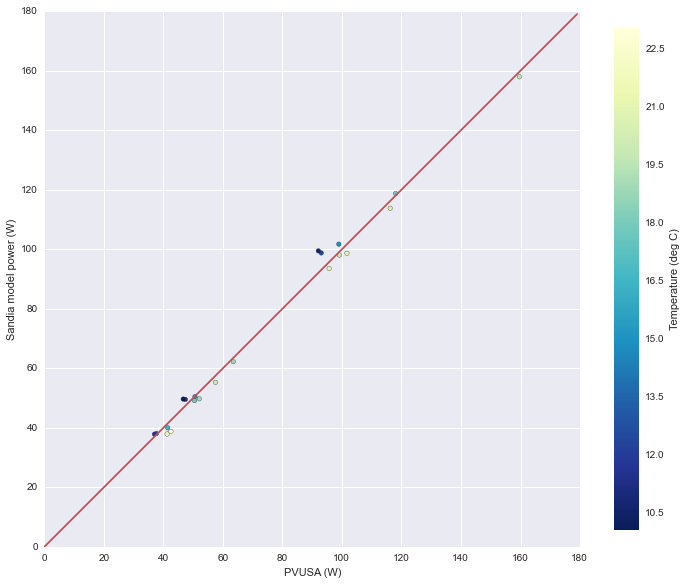

In [45]:
power_pvusa = pvusa(pvusa_data, *popt)

fig, ax = sapm_other_scatter(temperature[nonnull_idx], power_pvusa, clabel='Temperature (deg C)',
                             aspect_equal=True, xlabel='PVUSA (W)')

maxmax = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_ylim(None, maxmax)
ax.set_xlim(None, maxmax)
ax.plot(np.arange(maxmax), np.arange(maxmax), 'r')